Restarted GenAMM (Python 3.11.4)

In [1]:
import pickle
import qGaussian
import qPowerLaw
import qlogNormal
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from datetime import datetime
from scipy.stats import kstest
import matplotlib.pyplot as plt
from tradingstrategy.client import Client
from tradingstrategy.timebucket import TimeBucket
sns.set_theme()

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

dataset_path = '../data/usdc_weth_005.pickle'
with open(dataset_path, 'rb') as f:
    df = pickle.load(f)
df.index = pd.to_datetime(df.index)

df = df[ (df.index >= datetime(2023, 1, 1, 0, 0, 0)) & (df.index < datetime(2024, 1, 1, 0, 0, 0)) ]
df_swap = df[ (df.Event=='Swap_X2Y') | (df.Event=='Swap_Y2X') ]
df_mint = df[ df.Event=='Mint' ]
df_burn_mint = df[ (df.Event=='Burn') | (df.Event=='Mint') ]
df_burn = df[ df.Event=='Burn' ]

'''
df_burn_mint_full = df_burn_mint.copy()
df_burn_mint = df_burn_mint[['block_number', 'Event', 'tick_lower', 'tick_upper', 'amount0', 'amount1', 'amount']]
df_swap_full = df_swap.copy()
df_swap = df_swap[['block_number', 'Event', 'tick', 'liquidity', 'amount0', 'amount1', 'amount']]
'''

"\ndf_burn_mint_full = df_burn_mint.copy()\ndf_burn_mint = df_burn_mint[['block_number', 'Event', 'tick_lower', 'tick_upper', 'amount0', 'amount1', 'amount']]\ndf_swap_full = df_swap.copy()\ndf_swap = df_swap[['block_number', 'Event', 'tick', 'liquidity', 'amount0', 'amount1', 'amount']]\n"

In [2]:
# Import no L.O. data
with open('../data/df_mint_clean.pickle', 'rb') as f:
    df_mint_clean = pickle.load(f)

df_mint_clean[[
    'tick_lower', 'tick_upper', 'block_number', 'tick'
    ]] =df_mint_clean[[
        'tick_lower', 'tick_upper', 'block_number', 'tick']].astype(int)

block_delta = df_mint_clean.block_number.diff().values[1:]

# Import L.O. data
with open('../data/pseudo_lo.pickle', 'rb') as f:
    pseudo_lo = pickle.load(f)

pseudo_lo[[
    'block_start'
    ]] =pseudo_lo[[
        'block_start']].astype(int)

lo_block_delta = pseudo_lo.block_start.diff().values[1:]

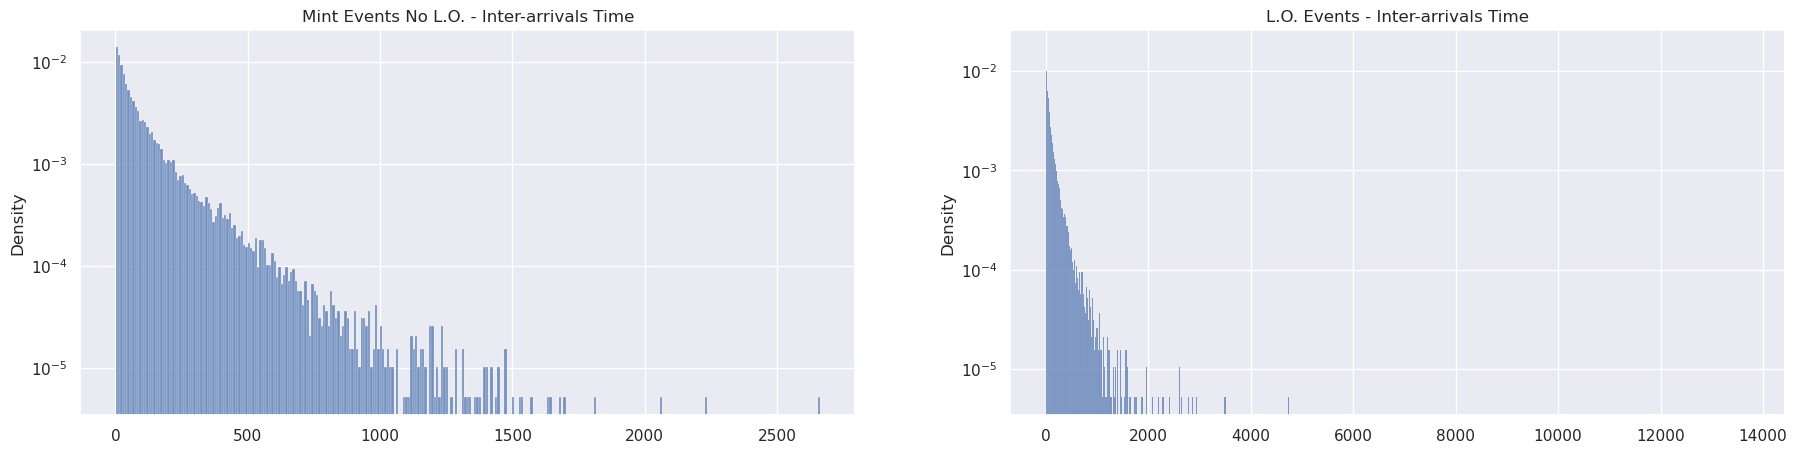

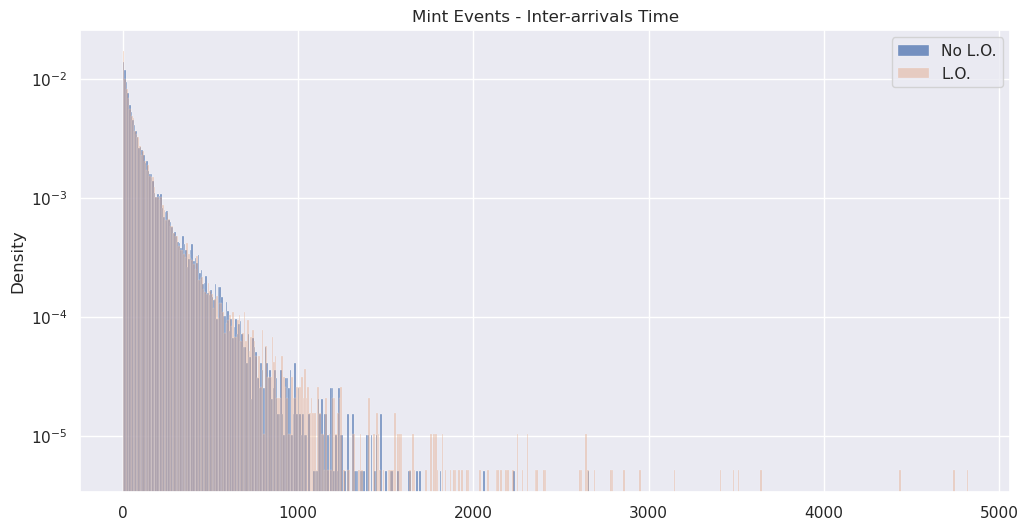

In [3]:
# Plot the data - Compare L.O. with No L.O.
fig, ax = plt.subplots(1, 2, figsize=(22, 5))

sns.histplot(block_delta, ax=ax[0], stat='density', label='Data')
ax[0].set_yscale('log')
ax[0].set_title("Mint Events No L.O. - Inter-arrivals Time")

sns.histplot(lo_block_delta, ax=ax[1], stat='density', label='Data')
ax[1].set_yscale('log')
ax[1].set_title("L.O. Events - Inter-arrivals Time")

plt.show()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_yscale('log')

sns.histplot(block_delta, ax=ax, stat='density', label='No L.O.')
sns.histplot(lo_block_delta[lo_block_delta <= 6_000], ax=ax, stat='density', label='L.O.', alpha=0.3)

plt.title("Mint Events - Inter-arrivals Time")
ax.legend()
plt.show()

(2.4656625622253987, -179.53200873433934, 180.5320087343393)


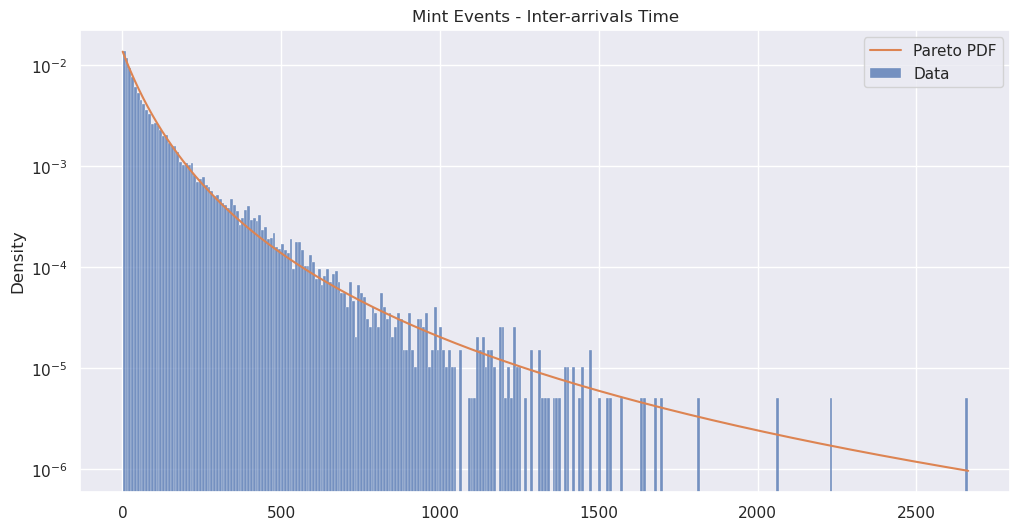

In [4]:
# Pareto fit - No lo
from scipy.stats import pareto
y_temp = block_delta.copy()

my_p_pars = pareto.fit(y_temp)
print(my_p_pars)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(y_temp, ax=ax, stat='density', label='Data')
ax.set_yscale('log')

pdf = pareto.pdf(np.linspace(np.min(y_temp), np.max(y_temp), 10000), *my_p_pars)
sns.lineplot(x=np.linspace(np.min(y_temp), np.max(y_temp), 10000),
             y=pdf,
            ax=ax, color=sns.color_palette()[1], label='Pareto PDF')

plt.title("Mint (no l.o.) Events - Inter-arrivals Time")
ax.legend()
plt.show()

(2.03316744536723, -136.87006618061096, 137.87006618061093)


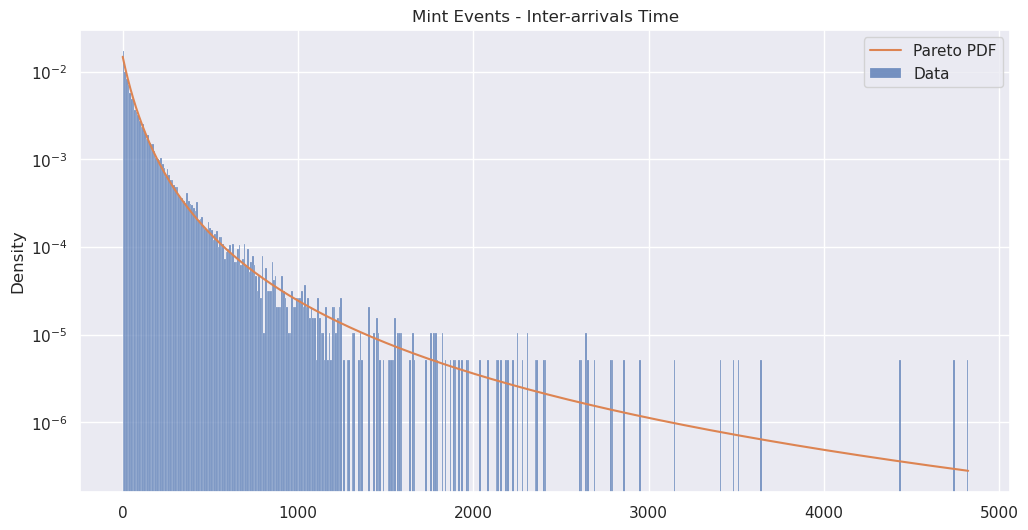

In [5]:
# Pareto fit
from scipy.stats import pareto
to_cut = 6_000
y_temp = lo_block_delta[lo_block_delta < to_cut]

my_p_pars = pareto.fit(y_temp)
print(my_p_pars)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(y_temp, ax=ax, stat='density', label='Data')
ax.set_yscale('log')

pdf = pareto.pdf(np.linspace(np.min(y_temp), np.max(y_temp), 10000), *my_p_pars)
sns.lineplot(x=np.linspace(np.min(y_temp), np.max(y_temp), 10000),
             y=pdf,
            ax=ax, color=sns.color_palette()[1], label='Pareto PDF')

plt.title("Mint Events - Inter-arrivals Time")
ax.legend()
plt.show()

In [6]:
# Comparison with other distributions
from scipy.stats import halfcauchy, fatiguelife, genpareto, kappa3
y_temp = block_delta.copy()

def general_ll(x, pdf_func, pars):
    return np.sum(np.log(pdf_func(x, *pars)))
    
max_ll, best_dist = -np.inf, None
for dist, name in zip([halfcauchy, fatiguelife, genpareto, kappa3, pareto, qPowerLaw],
                      ['Half-Cauchy', 'Fatigue Life', 'Generalized Pareto', 'Kappa 3', 'Pareto', 'qPowerLaw']):
    try:
        if name != 'qPowerLaw':
            pars = dist.fit(y_temp)
            print(f"{name} - Parameters: {pars}")
            curr_ll = general_ll(y_temp, dist.pdf, pars)
            print(f"{name} - Log-Likelihood: {curr_ll}")
            if curr_ll > max_ll:
                max_ll = curr_ll
                best_dist = name
        else:
            pars = dist.general_fit(y_temp)
            print(f"{name} - Parameters: {list(pars.values())[:-1]}")
            curr_ll = general_ll(y_temp, dist.pdf, list(pars.values())[:-1])
            print(f"{name} - Log-Likelihood: {curr_ll}")
            if curr_ll > max_ll:
                max_ll = curr_ll
                best_dist = name
    except Exception as e:
        print(f"{name} - Error: {e}")
    print('')

print(f"The best distribution is: {best_dist}, with a Log-Likelihood of {max_ll}")

Half-Cauchy - Parameters: (0.9999999874235053, 55.22623435257646)
Half-Cauchy - Log-Likelihood: -126090.78511688

Fatigue Life - Parameters: (1.4718086568138067, -2.8274883282819356, 57.82565996902515)
Fatigue Life - Log-Likelihood: -125494.03149744259

Generalized Pareto - Parameters: (0.4492412117323745, 0.9999999997433062, 64.11513666708518)
Generalized Pareto - Log-Likelihood: -125387.70140739024

Kappa 3 - Parameters: (1.4102147120605357, 0.9999999999905105, 63.657353292976744)
Kappa 3 - Log-Likelihood: -125623.6741090698

Pareto - Parameters: (2.4656625622253987, -179.53200873433934, 180.5320087343393)
Pareto - Log-Likelihood: -125321.4066378866

qPowerLaw - Parameters: [1.6855441837784373, 0.6376088421728566, 0.09670410479580198, -11.895179998731273, 12.8951523369544]
qPowerLaw - Log-Likelihood: -133966.99416082777

The best distribution is: Pareto, with a Log-Likelihood of -125321.4066378866


In [7]:
# Comparison with other distributions
to_cut = 6_000
y_temp = lo_block_delta[lo_block_delta < to_cut]

def general_ll(x, pdf_func, pars):
    return np.sum(np.log(pdf_func(x, *pars)))
    
max_ll, best_dist = -np.inf, None
for dist, name in zip([halfcauchy, fatiguelife, genpareto, kappa3, pareto, qPowerLaw],
                      ['Half-Cauchy', 'Fatigue Life', 'Generalized Pareto', 'Kappa 3', 'Pareto', 'qPowerLaw']):
    try:
        if name != 'qPowerLaw':
            pars = dist.fit(y_temp)
            print(f"{name} - Parameters: {pars}")
            curr_ll = general_ll(y_temp, dist.pdf, pars)
            print(f"{name} - Log-Likelihood: {curr_ll}")
            if curr_ll > max_ll:
                max_ll = curr_ll
                best_dist = name
        else:
            pars = dist.general_fit(y_temp)
            print(f"{name} - Parameters: {list(pars.values())[:-1]}")
            curr_ll = general_ll(y_temp, dist.pdf, list(pars.values())[:-1])
            print(f"{name} - Log-Likelihood: {curr_ll}")
            if curr_ll > max_ll:
                max_ll = curr_ll
                best_dist = name
    except Exception as e:
        print(f"{name} - Error: {e}")
    print('')

print(f"The best distribution is: {best_dist}, with a Log-Likelihood of {max_ll}")

Half-Cauchy - Parameters: (0.9999999989987014, 54.12376725365203)
Half-Cauchy - Log-Likelihood: -118146.46573589981

Fatigue Life - Parameters: (1.6199911280552248, -2.2396684679413363, 54.52639672848837)
Fatigue Life - Log-Likelihood: -117841.87238973653

Generalized Pareto - Parameters: (0.49193682239258296, 0.9999999977476575, 67.81450597182325)
Generalized Pareto - Log-Likelihood: -117436.50060472591

Kappa 3 - Parameters: (1.312042410024587, 0.9999999999239937, 59.756042810654534)
Kappa 3 - Log-Likelihood: -117698.5921057223

Pareto - Parameters: (2.03316744536723, -136.87006618061096, 137.87006618061093)
Pareto - Log-Likelihood: -117436.50048849659

qPowerLaw - Parameters: [0.9207607174337916, 0.6134282049750536, 0.010594088938851286, -19.512976165989766, 20.22374228699869]
qPowerLaw - Log-Likelihood: -118598.18470532782

The best distribution is: Pareto, with a Log-Likelihood of -117436.50048849659


In [8]:
# Comparison test
class Fit_comparison_test():
    '''
    Fit comparison test for assessing the goodness of the Expected Shortfall estimate
    '''
    def __init__(self, one_side=True, n_boot=10_000):
        '''
        Args:
            one_side (bool): if True, the test is one sided (i.e. H0: mu >= mu_target). Default is False
            n_boot (int): the number of bootstrap replications. Default is 10_000
        '''
        self.mu_target = 0
        self.one_side = one_side
        self.n_boot = n_boot
    
    def null_statistic(self, B_data):
        '''
        Compute the null statistic for the bootstrap sample
        Args:
            B_data (numpy array): the bootstrap sample

        Returns:
            float: the null statistic
        '''
        return (np.mean(B_data) - self.obs_mean) * np.sqrt(self.n) / np.std(B_data)
    
    def statistic(self, data):
        '''
        Compute the test statistic for the original sample
        Args:
            data (numpy array): the original sample

        Returns:
            float: the test statistic
        '''
        return (self.obs_mean - self.mu_target) * np.sqrt(self.n) / np.std(data)
    
    def fit_transform(self, data, pdf1, pdf2):
        '''
        Transform the data to compute the Fit comparison test
        Args:
            Q_ (numpy array): the quantile estimates
            E_ (numpy array): the expected shortfall estimates
            Y_ (numpy array): the actual time series

        Returns:
            numpy array: the transformed data
        '''

        return np.log((pdf2(data))) - np.log(pdf1(data))

    def __call__(self, x, pdf_func_top, pdf_func_bench, seed=None):
        '''
        Compute the test

        Args:
            Q (numpy array): the quantile estimates
            E (numpy array): the expected shortfall estimates
            Y (numpy array): the actual time series
            seed (int): the seed for the random number generator. Default is None

        Returns:
            dict: a dictionary with the following keys_ 'statistic' (float; the test statistic), 'p_value' (float; the p-value of the test)
        '''
        data = self.fit_transform(x, pdf_func_top, pdf_func_bench)
        np.random.seed(seed)

        self.obs_mean = np.mean(data)
        self.n = len(data)

        B_stats = list()
        for _ in range(self.n_boot):
            B_stats.append( self.null_statistic(
                np.random.choice(data, size=self.n, replace=True) ))
        B_stats = np.array(B_stats)
        self.B_stats = B_stats
        
        if self.one_side:
            obs = self.statistic(data)
            return {'statistic':obs, 'p_value':np.mean(B_stats < obs)}
        else:
            obs = np.abs(self.statistic(data))
            return {'statistic':self.statistic(data),
                    'p_value':np.mean((B_stats > obs) | (B_stats < -obs))}

y_temp = block_delta.copy()

boot_test = Fit_comparison_test(one_side=True, n_boot=10_000)
random_seed = 2

top_dist = pareto
top_pars = top_dist.fit(y_temp)
for dist, name in zip([halfcauchy, genpareto, kappa3, fatiguelife, qPowerLaw],
                      ['Half-Cauchy', 'Generalized Pareto', 'Kappa 3', 'FatigueLife', 'qPowerLaw']):
    if name != 'qPowerLaw':
        temp_par = dist.fit(y_temp)
        test_res = boot_test(
            y_temp, lambda x: top_dist.pdf(x, *top_pars),
            lambda x: dist.pdf(x, *temp_par), random_seed)
    else:
        temp_par = dist.fit(y_temp)
        test_res = boot_test(
            y_temp, lambda x: top_dist.pdf(x, *top_pars),
            lambda x: dist.pdf(x, *list(temp_par.values())[:-1]), random_seed)
    print(f"{name} - test result: {test_res}")

Half-Cauchy - test result: {'statistic': -38.53329309982221, 'p_value': 0.0}
Generalized Pareto - test result: {'statistic': -5.289553957314165, 'p_value': 0.0}
Kappa 3 - test result: {'statistic': -28.731084047223256, 'p_value': 0.0}
FatigueLife - test result: {'statistic': -6.277208596563587, 'p_value': 0.0}
qPowerLaw - test result: {'statistic': -62.86590124226446, 'p_value': 0.0}


In [12]:
# Comparison test
to_cut = 6_000
y_temp = lo_block_delta[lo_block_delta < to_cut]

boot_test = Fit_comparison_test(one_side=True, n_boot=10_000)
random_seed = 2

top_dist = pareto
top_pars = top_dist.fit(y_temp)
for dist, name in zip([halfcauchy, genpareto, kappa3, fatiguelife, qPowerLaw],
                      ['Half-Cauchy', 'Generalized Pareto', 'Kappa 3', 'FatigueLife', 'qPowerLaw']):
    if name != 'qPowerLaw':
        temp_par = dist.fit(y_temp)
        test_res = boot_test(
            y_temp, lambda x: top_dist.pdf(x, *top_pars),
            lambda x: dist.pdf(x, *temp_par), random_seed)
    else:
        temp_par = dist.fit(y_temp)
        test_res = boot_test(
            y_temp, lambda x: top_dist.pdf(x, *top_pars),
            lambda x: dist.pdf(x, *list(temp_par.values())[:-1]), random_seed)
    print(f"{name} - test result: {test_res}")

Half-Cauchy - test result: {'statistic': -37.549804204724296, 'p_value': 0.0}
Generalized Pareto - test result: {'statistic': -0.00835958055269112, 'p_value': 0.4972}
Kappa 3 - test result: {'statistic': -26.88292897491669, 'p_value': 0.0}
FatigueLife - test result: {'statistic': -10.230824005308499, 'p_value': 0.0}
qPowerLaw - test result: {'statistic': -21.244603591608822, 'p_value': 0.0}


In [13]:
# Direct test
y_temp = block_delta.copy()

from scipy.stats import kstest

my_p_pars = pareto.fit(y_temp)
print(kstest(y_temp, 'pareto', args=my_p_pars))

from scipy.stats import chi2
from scipy.special import xlogy

def g_test_discrete(data, distribution, params):
    # Get unique values and their frequencies
    unique, counts = np.unique(data, return_counts=True)
    n = len(data)
    
    # Calculate expected frequencies
    expected = n * distribution.pdf(unique, *params)
    
    # Combine bins with expected frequency < 5
    mask = expected >= 5
    if not all(mask):
        unique = unique[mask]
        counts = counts[mask]
        expected = expected[mask]
        # Add a final bin for all remaining values
        counts = np.append(counts, n - counts.sum())
        expected = np.append(expected, n - expected.sum())
    
    # Calculate G-statistic
    g_stat = 2 * np.sum(xlogy(counts, counts / expected))
    
    # Calculate degrees of freedom
    df = len(counts) - 1 - len(params)
    
    # Calculate p-value
    p_value = 1 - chi2.cdf(g_stat, df)
    
    print("\nG-test (Likelihood Ratio Test) Results:")
    print(f"G-statistic: {g_stat}")
    print(f"p-value: {p_value}")
    
    # Interpret the results
    alpha = 0.05  # significance level
    if p_value > alpha:
        print("Fail to reject the null hypothesis. The data may follow the specified distribution.")
    else:
        print("Reject the null hypothesis. The data may not follow the specified distribution.")
g_test_discrete(y_temp, pareto, my_p_pars)

KstestResult(statistic=0.031124366917993362, pvalue=6.099357637808139e-19, statistic_location=21.0, statistic_sign=1)

G-test (Likelihood Ratio Test) Results:
G-statistic: 648.4528830293278
p-value: 1.9695356456850277e-13
Reject the null hypothesis. The data may not follow the specified distribution.


In [14]:
# Direct test
to_cut = 6_000
y_temp = lo_block_delta[lo_block_delta < to_cut]

my_p_pars = pareto.fit(y_temp)
print(kstest(y_temp, 'pareto', args=my_p_pars))

g_test_discrete(y_temp, pareto, my_p_pars)

KstestResult(statistic=0.040055350149740016, pvalue=4.0789633168765857e-29, statistic_location=10.0, statistic_sign=1)

G-test (Likelihood Ratio Test) Results:
G-statistic: 659.1754515066158
p-value: 8.881784197001252e-16
Reject the null hypothesis. The data may not follow the specified distribution.
